In [40]:
import numpy as np
from scipy.stats import norm, expon, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

# Plotting parameters
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [60]:
def hmc_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
                delta: float = 0.3,
                L: float = 20,
                x0: np.array = np.array([0,6]).T
               ) -> None:
    """
    A toy application of HMC to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param delta step size for leap-frog
    :param L # of steps for leap-frog to take per sample
    :param x0 starting position
    :return None
    """
   
    delta = 0.3 # step size, keeping it fixed to break it
    n_samples = 10000
    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x) # potential
    dU = lambda x: np.dot(x.T, np.linalg.inv(M)) # gradient
    K = lambda p: np.dot(p.T, p) * 0.5 # Kinetic Energy

    x = [x0]

    t = 1
    accepted = 0 # keep track of acceptance rate
    for _ in range(n_samples):
        # sampling loop
        p0 = norm.rvs(size = 2).T # sample momentum

        # start SV steps
        pStar = p0 - delta / 2 * dU(x[-1]).T

        xStar = x[-1] + delta * pStar

        for j in range(L-1):
            pStar = pStar - delta * dU(xStar).T

            xStar = xStar + delta * pStar

        pStar = pStar - delta / 2 * dU(xStar).T

        U0 = U(x[-1])
        UStar = U(xStar)

        K0 = K(p0)
        KStar = K(pStar)
        # acceptance probability, difference in initial and final energy/Hamiltonian
        alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))

        u = uniform.rvs()
        if u < alpha:
            x.append(xStar)
            accepted += 1
        else:
            x.append(x[-1])

    print(f"HMC Acceptance Rate: {accepted / n_samples:.3f}")
    x = np.array(x)

    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(x[50:,0], x[50:,1], '.', color='blue')
    _ = plt.plot(x[:50,0], x[:50,1], 'o-', color='red', label = "First 50 samples")
    plt.xlim([-4,4])
    plt.legend()
    title_str = 'Hamiltonian Monte Carlo\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)

    

def mh_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
               x0: np.array = np.array([0,6]).T
              ) -> None:
    """
    A toy application of Metropolis-Hastings to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param x0 starting position
    :return None
    """
    n_samples = 10000

    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x)
    x0 = np.array([0,6]).T
    y = [x0]

    accepted = 0
    for _ in range(n_samples):

        yStar = y[-1] + norm.rvs(size=2, scale=0.7)
        U0 = U(y[-1])
        UStar = U(yStar)

        alpha = min(1, np.exp((U0)-(UStar)))

        u = uniform.rvs()
        if u < alpha:
            y.append(yStar)
            accepted += 1
        else:
            y.append(y[-1])
            
    print(f"\nMetropolis-Hastings Acceptance Rate: {accepted / n_samples}")
    y = np.array(y)


    
    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(y[50:,0], y[50:,1], '.', color = 'blue')
    _ = plt.plot(y[:50,0], y[:50,1], 'o-', color = 'red', label = "First 50 samples")
    plt.xlim([-4, 4])
    plt.legend()
    title_str = 'Metropolis-Hastings\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)
    

def compare_and_plot(M: np.array = np.array([[1,0],[0,1]]),
                     delta: float = 0.3,
                     L: float = 20,
                     x0: np.array = np.array([0,6]).T
                    ) -> None:
    mh_gauss2d(M, x0 = x0)
    hmc_gauss2d(M, delta = delta, L = L, x0 = x0)

## Compare exploration between M-H and HMC

Metropolis-Hastings Acceptance Rate: 0.5505
HMC Acceptance Rate: 0.789


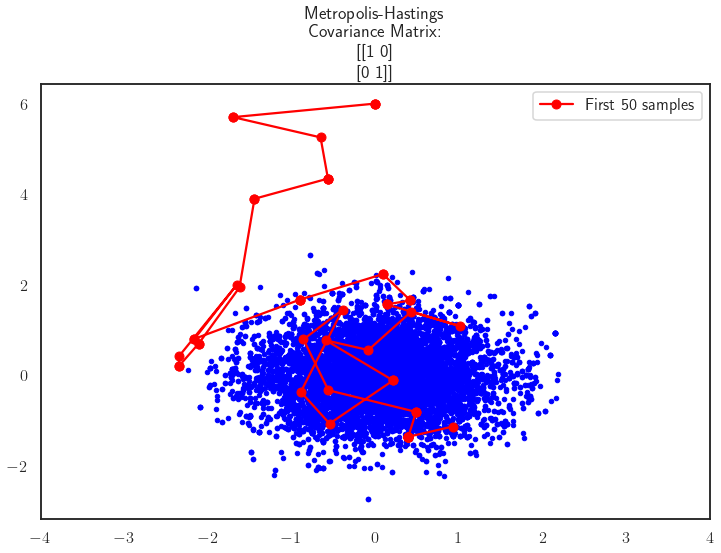

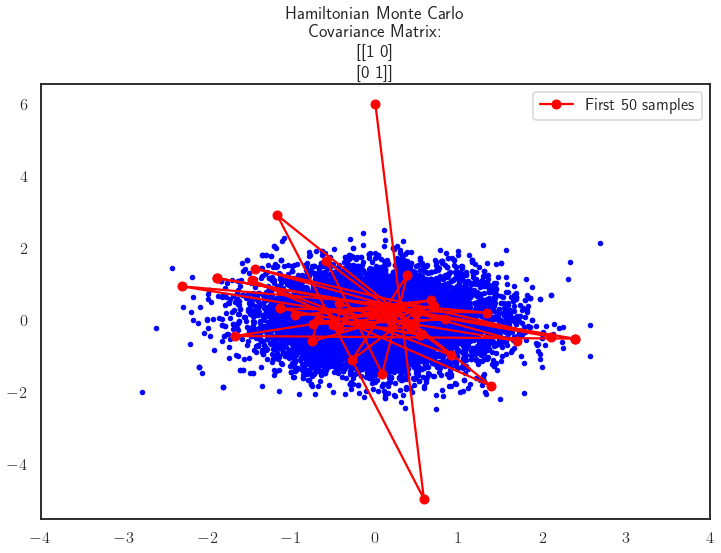

In [4]:
compare_and_plot(L = 50)

In [5]:
def stormer_verlet(q, p ,h ,n , dU, dK):
    Q = [q]
    P = [p]
    for i in range(n):
        p = P[i] - (h / 2) * dU(Q[i])
        Q.append(Q[i] + h * dK(p))
        P.append(p - (h / 2) * dU(Q[i+1]))
    return np.array(Q), np.array(P)

In [6]:
K = lambda p: np.dot(p,p) / 2
dK = lambda p: p
U = lambda q: -1 / (np.dot(q,q) ** 0.5)
dU = lambda q: q / (np.dot(q,q) ** 1.5)
H = lambda q,p: K(p) + U(q)

def initial_conditions(e):
    q0 = np.array([1 - e, 0])
    p0 = np.array([0, np.sqrt((1 + e) / (1 - e))])
    return q0, p0

def energy(Q, P, H):
    hamiltonian = []
    for q, p in zip(Q,P):
        hamiltonian.append(H(q,p))
    return hamiltonian

## Energy error for standard $\textbf{St}\mathbf{\ddot{o}}\textbf{rmer-Verlet}$ 100,000 step orbit.
Left plot is target parameters $[q_1,q_2]^{\top}$.
Right plot is energy error.

CPU times: user 1.95 s, sys: 299 ms, total: 2.25 s
Wall time: 1.95 s


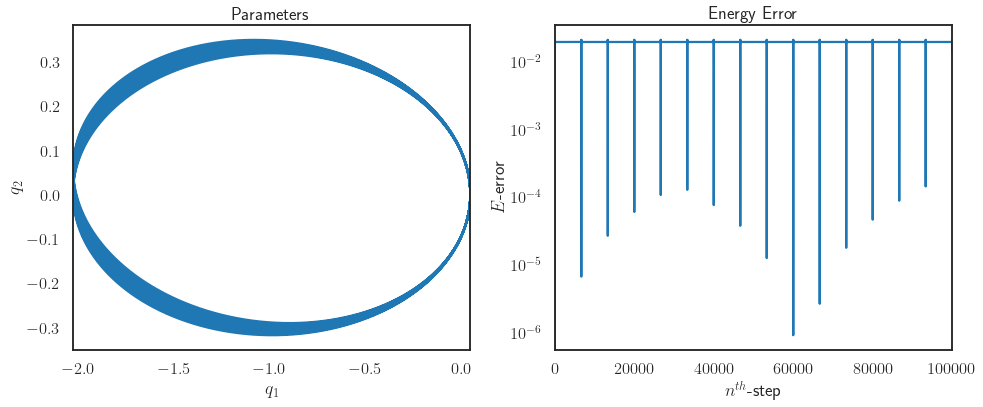

In [12]:
%%time
n = 100000
h = 0.001
e = 0.95
q0,p0 = initial_conditions(e)
Q, P = stormer_verlet(q0, p0, h, n, dU, dK)
energy_error = np.abs(energy(Q, P, H) - H(q0,p0))
fig, axs = plt.subplots(1,2, figsize = (14,6))
axs[0].plot(Q[:,0], Q[:,1])
axs[0].set_xlabel('$q_1$')
axs[0].set_ylabel('$q_2$')
axs[0].title.set_text('Parameters')
axs[1].plot(np.arange(n+1),energy_error)
axs[1].set_yscale("log")
axs[1].title.set_text('Energy Error')
axs[1].set_xlabel('$n^{th}$-step')
axs[1].set_ylabel('$E$-error')
plt.tight_layout()

In [13]:
def adap_stormer_verlet(q, p ,h ,n , dU, dK, G):
    max_time = h * n
    total_time = 0
    Q = [q]
    P = [p]
    T = [1 - (h / 2) * G(q,p)]
    for i in range(n):
        T.append(T[i] + h * G(Q[i],P[i]))
        p = P[i] - (h / 2) * dU(Q[i]) / T[i + 1]
        Q.append(Q[i] + h * dK(p) / T[i + 1])
        P.append(p - (h / 2) * dU(Q[i+1]) / T[i + 1])
        total_time += h / T[i + 1]
        if total_time >= max_time:
            break
    return np.array(Q), np.array(P), T

In [14]:
# Monitor function
G = lambda q,p: (-3 / 2) * np.dot(q,p) / np.dot(q,q)

CPU times: user 334 ms, sys: 90.1 ms, total: 424 ms
Wall time: 1.31 s


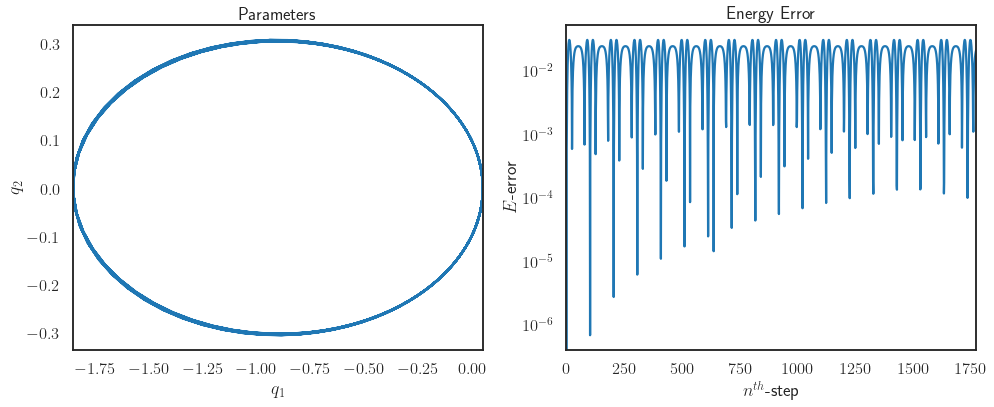

In [15]:
%%time
n = 100000
h = 0.001
e = 0.95
q0,p0 = initial_conditions(e)
Q, P, T = adap_stormer_verlet(q0, p0, h, n, dU, dK, G)
energy_error = np.abs(energy(Q, P, H)-H(q0,p0))
fig, axs = plt.subplots(1,2, figsize = (14,6))
axs[0].plot(Q[:,0], Q[:,1])
axs[1].plot(np.arange(Q.shape[0]),energy_error)
axs[1].set_yscale("log")
axs[0].set_xlabel('$q_1$')
axs[0].set_ylabel('$q_2$')
axs[0].title.set_text('Parameters')
axs[1].title.set_text('Energy Error')
axs[1].set_xlabel('$n^{th}$-step')
axs[1].set_ylabel('$E$-error')
plt.tight_layout()

In [37]:
def adap_hmc_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
                delta: float = 0.3,
                L: float = 20,
                x0: np.array = np.array([0,6]).T
               ) -> None:
    """
    A toy application of HMC to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param delta step size for leap-frog
    :param L # of steps for leap-frog to take per sample
    :param x0 starting position
    :return None
    """
   
    delta = 0.3 # step size, keeping it fixed to break it
    n_samples = 10000
    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x) # potential
    dU = lambda x: np.dot(x.T, np.linalg.inv(M)) # gradient
    K = lambda p: np.dot(p.T, p) * 0.5 # Kinetic Energy
    dK = lambda p: p

    x = [x0]

    t = 1
    accepted = 0 # keep track of acceptance rate
    
    max_time = delta * L
    
    for _ in range(n_samples):
        # sampling loop
        p0 = norm.rvs(size = 2).T # sample momentum

        total_time = 0
        # initial variable step size divisor
        tStar = 1 - (delta / 2) * G(x[-1], p0)
        # start SV steps
        pStar = p0 - (delta / 2) * dU(x[-1]).T / tStar

        xStar = x[-1] + delta * pStar / tStar
        
        total_time += delta / tStar
        
        for j in range(L-1):
            pStar = pStar - delta * dU(xStar).T / tStar

            xStar = xStar + delta * pStar / tStar
            
            total_time += delta / tStar
            if total_time >= max_time:
                break

        pStar = pStar - (delta / 2) * dU(xStar).T / tStar

        U0 = U(x[-1])
        UStar = U(xStar)

        K0 = K(p0)
        KStar = K(pStar)
        # acceptance probability, difference in initial and final energy/Hamiltonian
        alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))

        u = uniform.rvs()
        if u < alpha:
            x.append(xStar)
            accepted += 1
        else:
            x.append(x[-1])

    print(f"Adaptive HMC Acceptance Rate: {accepted / n_samples:.3f}")
    x = np.array(x)

    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(x[50:,0], x[50:,1], '.', color='blue')
    _ = plt.plot(x[:50,0], x[:50,1], 'o-', color='red', label = "First 50 samples")
    plt.xlim([-4,4])
    plt.legend()
    title_str = 'Adaptive Hamiltonian Monte Carlo\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)

In [61]:
def compare_and_plot(M: np.array = np.array([[1,0],[0,1]]),
                     delta: float = 0.3,
                     L: float = 20,
                     x0: np.array = np.array([0,6]).T
                    ) -> None:
    start = time.time()
    mh_gauss2d(M, x0 = x0)
    print(f'M-H runtime: {(time.time()-start):.2f}')
    
    start = time.time()
    hmc_gauss2d(M, delta = delta, L = L, x0 = x0)
    print(f'HMC runtime: {(time.time()-start):.2f}')
    
    start = time.time()
    adap_hmc_gauss2d(M, delta = delta, L = L, x0 = x0)
    print(f'A-HMC runtime: {(time.time()-start):.2f}')


Metropolis-Hastings Acceptance Rate: 0.5525
M-H runtime: 1.09
HMC Acceptance Rate: 0.793
HMC runtime: 6.43


/tmp/ipykernel_1798158/2770251327.py:47: RuntimeWarning: overflow encountered in true_divide
  xStar = xStar + delta * pStar / tStar


Adaptive HMC Acceptance Rate: 0.855
A-HMC runtime: 7.94


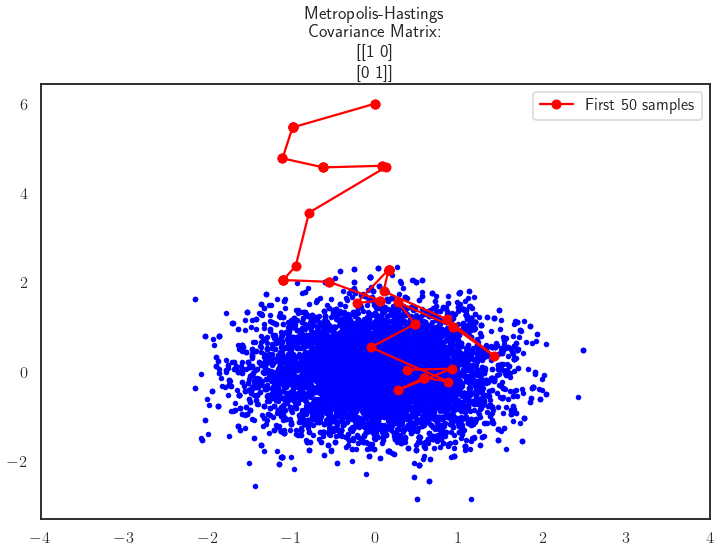

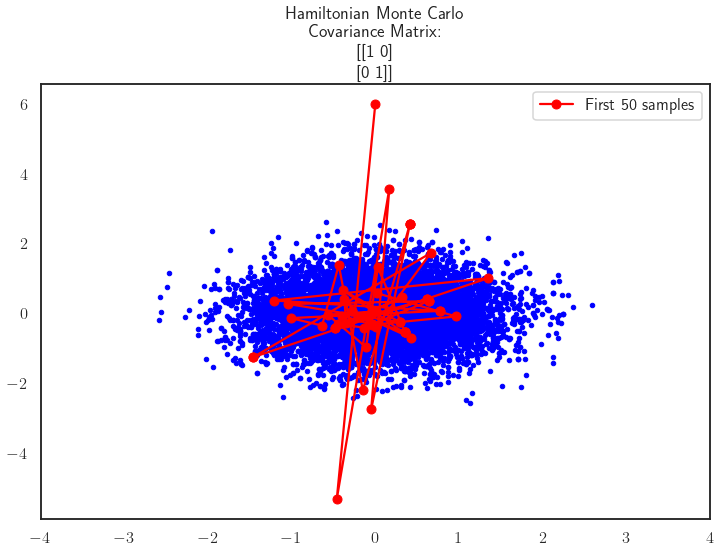

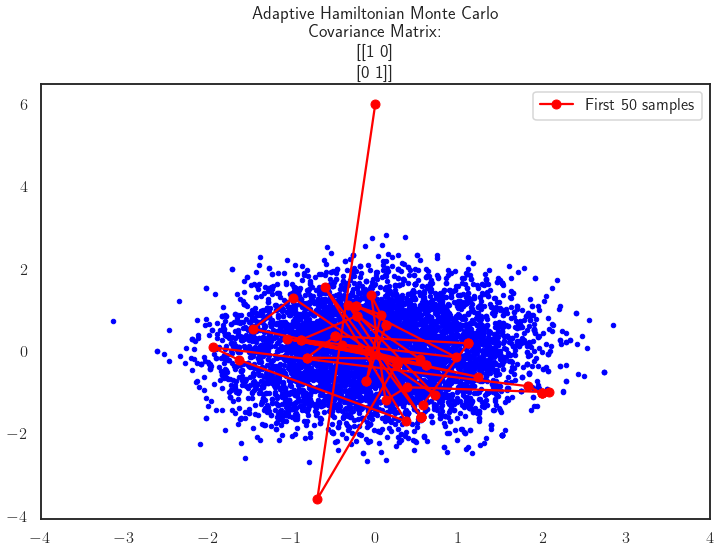

In [62]:
compare_and_plot(L = 50)


Metropolis-Hastings Acceptance Rate: 0.3727
M-H runtime: 1.05
HMC Acceptance Rate: 0.819
HMC runtime: 6.03


/tmp/ipykernel_1798158/2770251327.py:45: RuntimeWarning: invalid value encountered in subtract
  pStar = pStar - delta * dU(xStar).T / tStar


Adaptive HMC Acceptance Rate: 0.888
A-HMC runtime: 7.59


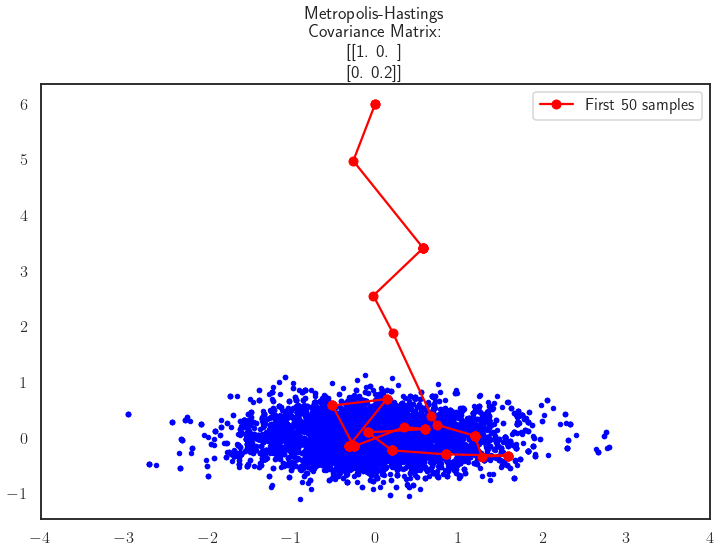

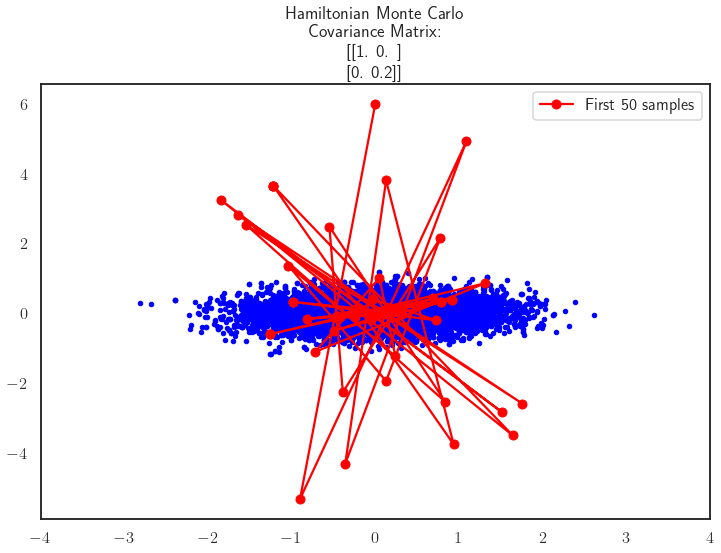

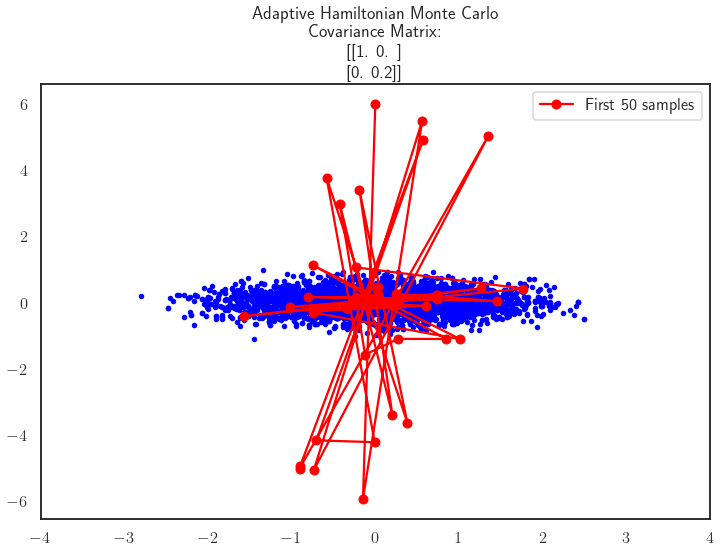

In [63]:
M = np.array([[1,0],[0,0.2]])
compare_and_plot(M = M, L = 50)


Metropolis-Hastings Acceptance Rate: 0.2897
M-H runtime: 1.15
HMC Acceptance Rate: 0.713
HMC runtime: 5.96
Adaptive HMC Acceptance Rate: 0.669
A-HMC runtime: 7.03


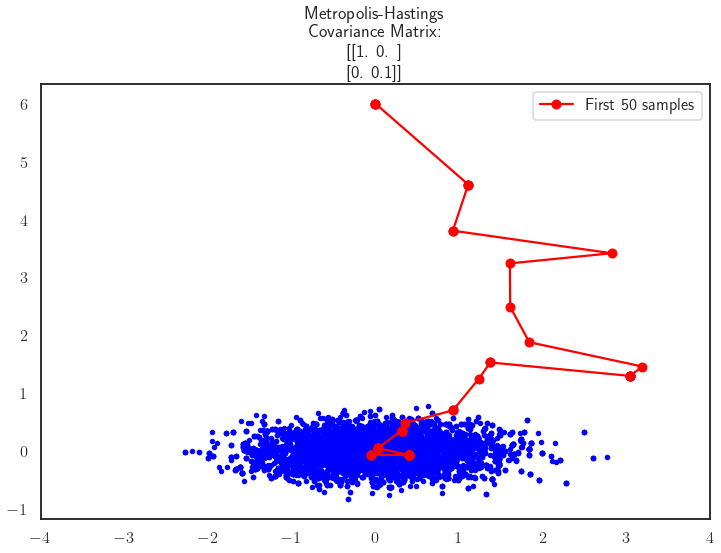

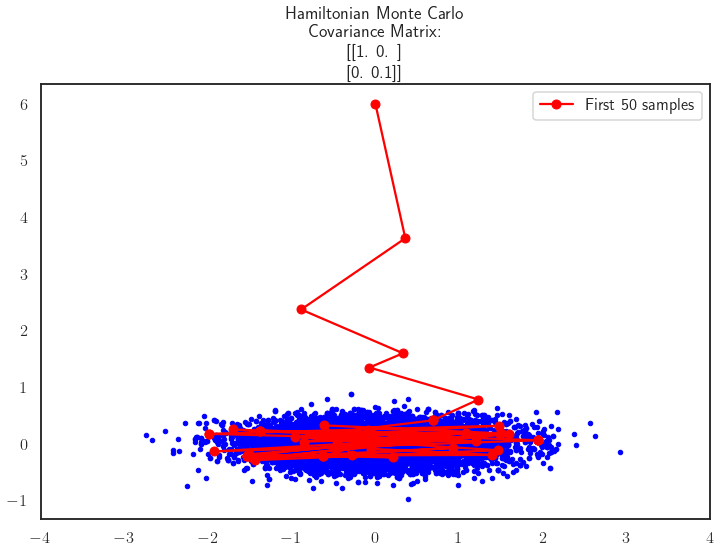

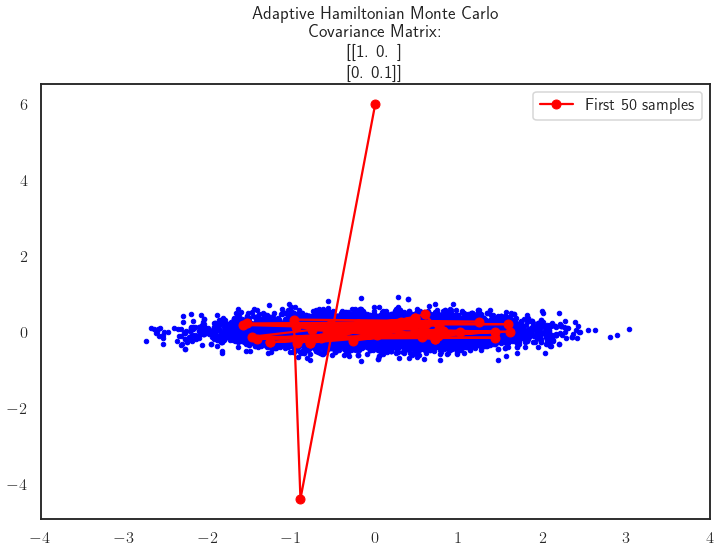

In [64]:
M = np.array([[1,0],[0,0.1]])
compare_and_plot(M = M, L = 50)


Metropolis-Hastings Acceptance Rate: 0.3227
M-H runtime: 1.06
HMC Acceptance Rate: 0.666
HMC runtime: 5.95


/tmp/ipykernel_1798158/2770251327.py:47: RuntimeWarning: overflow encountered in true_divide
  xStar = xStar + delta * pStar / tStar
/tmp/ipykernel_1798158/2770251327.py:47: RuntimeWarning: invalid value encountered in add
  xStar = xStar + delta * pStar / tStar


Adaptive HMC Acceptance Rate: 0.976
A-HMC runtime: 7.83


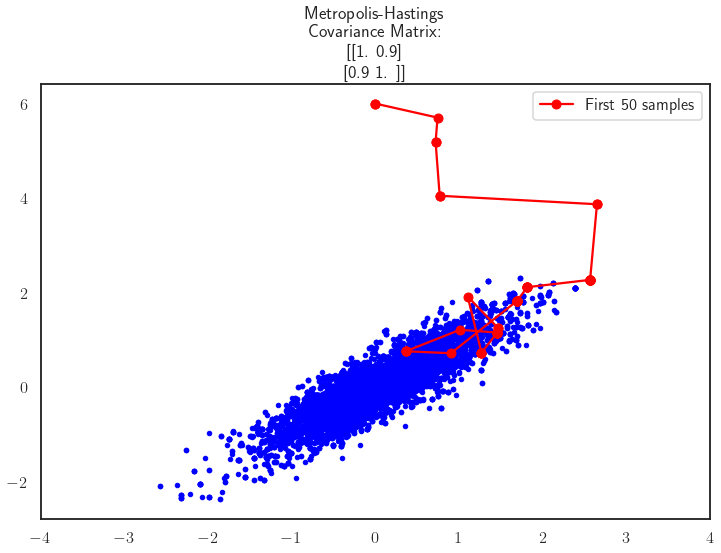

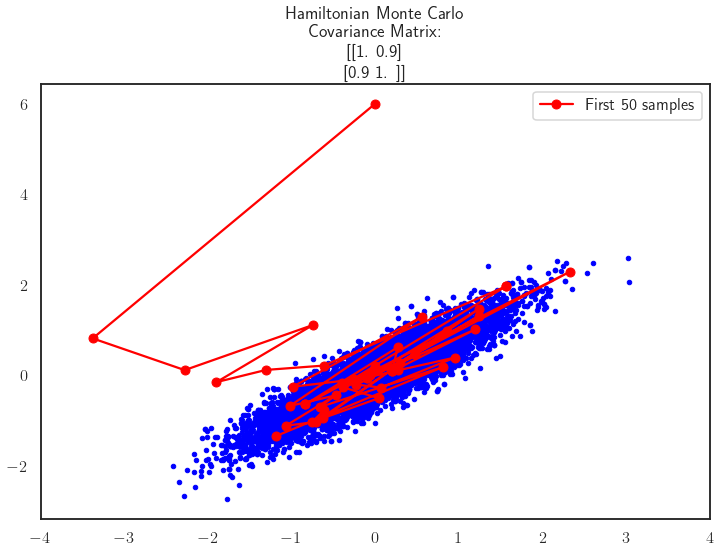

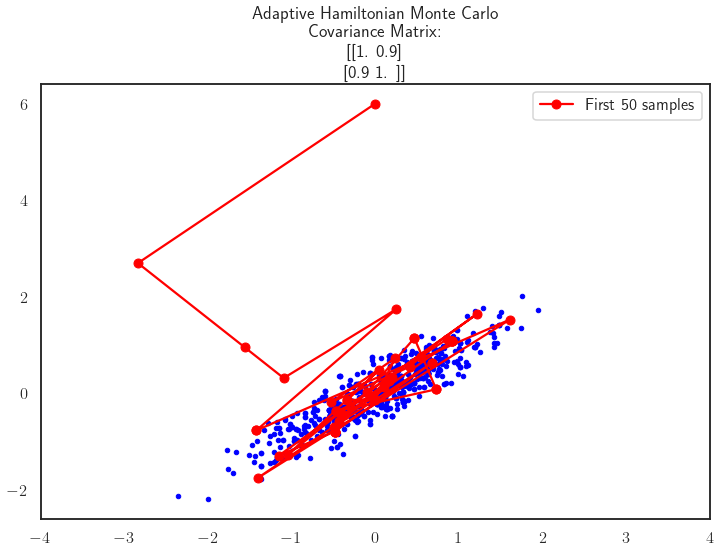

In [69]:
M = np.array([[1,0.9],[0.9,1]])
compare_and_plot(M = M, L = 50)


Metropolis-Hastings Acceptance Rate: 0.237
M-H runtime: 1.06
HMC Acceptance Rate: 0.544
HMC runtime: 5.93


/tmp/ipykernel_1798158/2770251327.py:47: RuntimeWarning: overflow encountered in true_divide
  xStar = xStar + delta * pStar / tStar
/tmp/ipykernel_1798158/2770251327.py:45: RuntimeWarning: overflow encountered in true_divide
  pStar = pStar - delta * dU(xStar).T / tStar
/tmp/ipykernel_1798158/2770251327.py:45: RuntimeWarning: invalid value encountered in subtract
  pStar = pStar - delta * dU(xStar).T / tStar


Adaptive HMC Acceptance Rate: 0.702
A-HMC runtime: 7.33


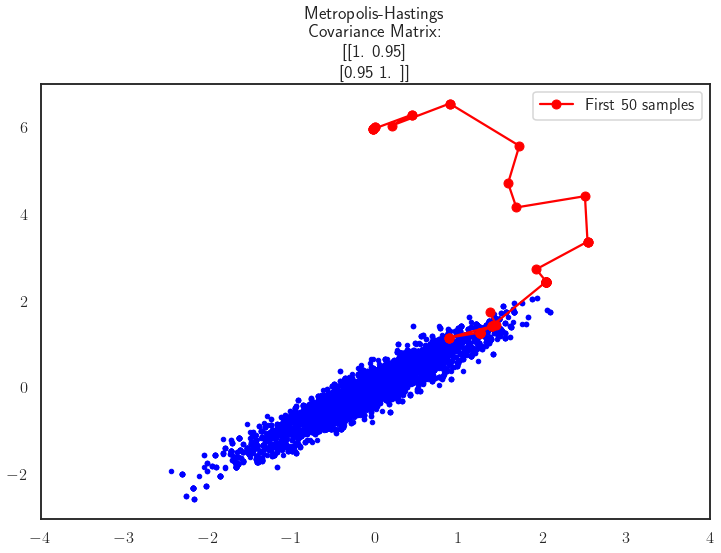

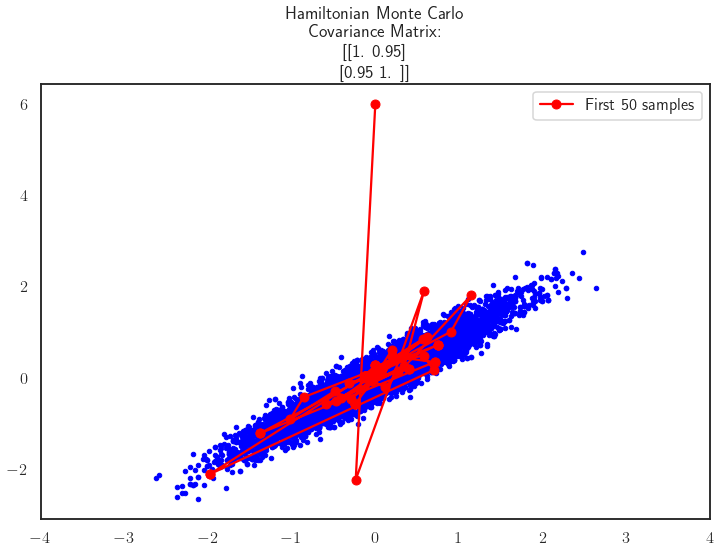

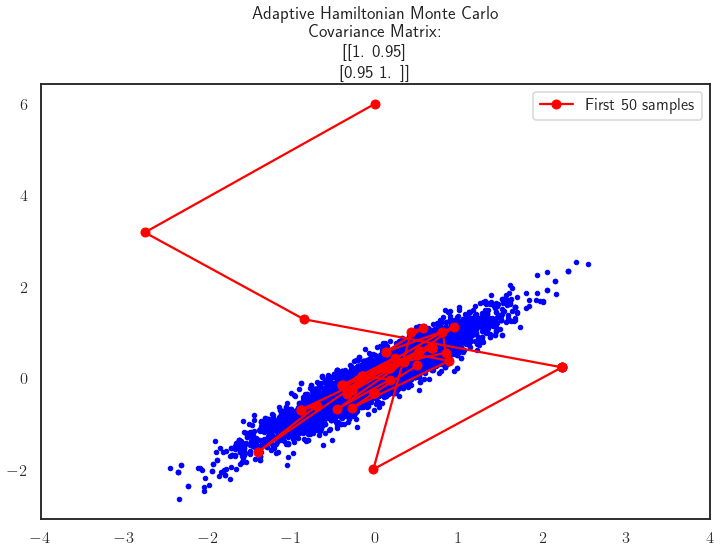

In [70]:
M = np.array([[1,0.95],[0.95,1]])
compare_and_plot(M = M, L = 50)


Metropolis-Hastings Acceptance Rate: 0.1645
M-H runtime: 1.04
HMC Acceptance Rate: 0.000
HMC runtime: 5.98


/tmp/ipykernel_1798158/2770251327.py:61: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))


Adaptive HMC Acceptance Rate: 0.001
A-HMC runtime: 7.76


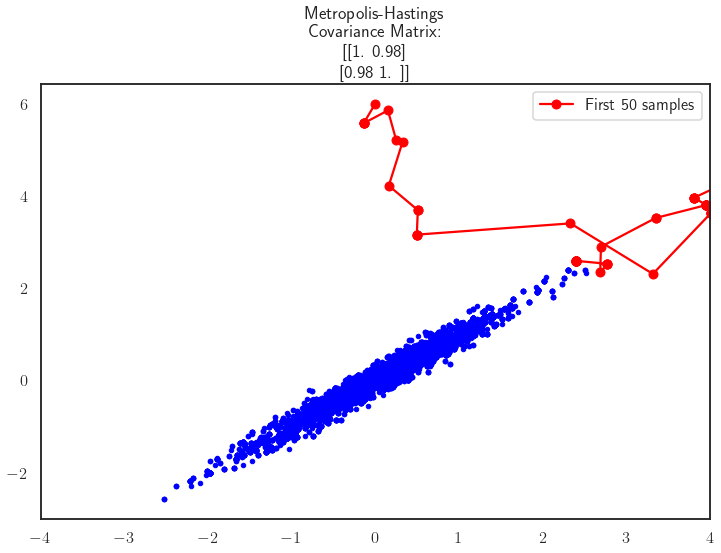

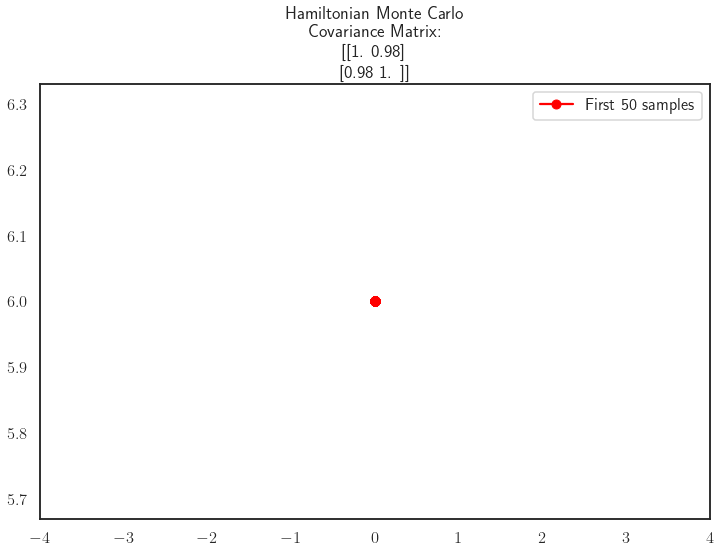

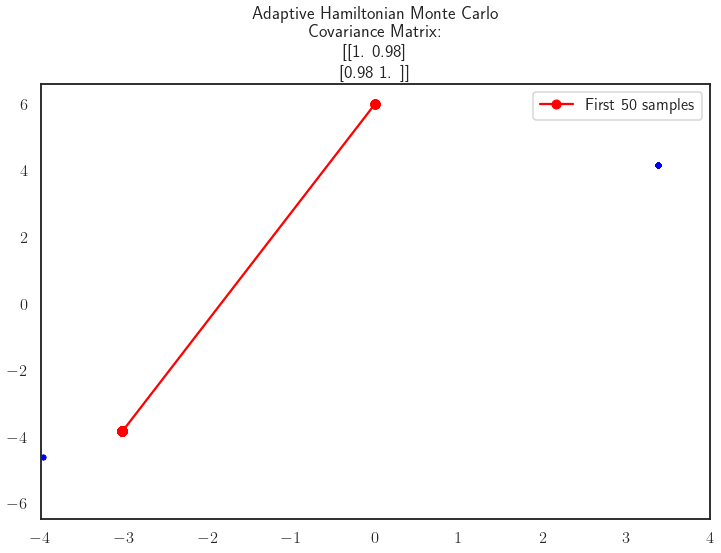

In [71]:
M = np.array([[1,0.98],[0.98,1]])
compare_and_plot(M = M, L = 50)


Metropolis-Hastings Acceptance Rate: 0.1559
M-H runtime: 1.10
HMC Acceptance Rate: 0.000
HMC runtime: 3.28


/tmp/ipykernel_1798158/2770251327.py:61: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))


Adaptive HMC Acceptance Rate: 0.011
A-HMC runtime: 3.94


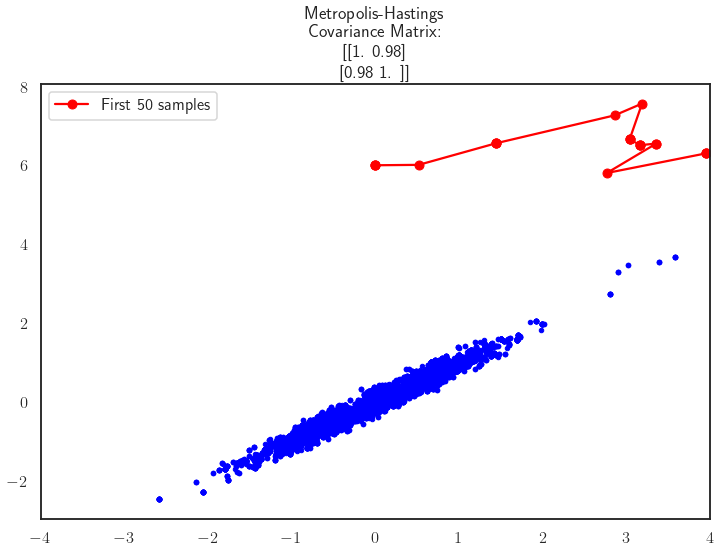

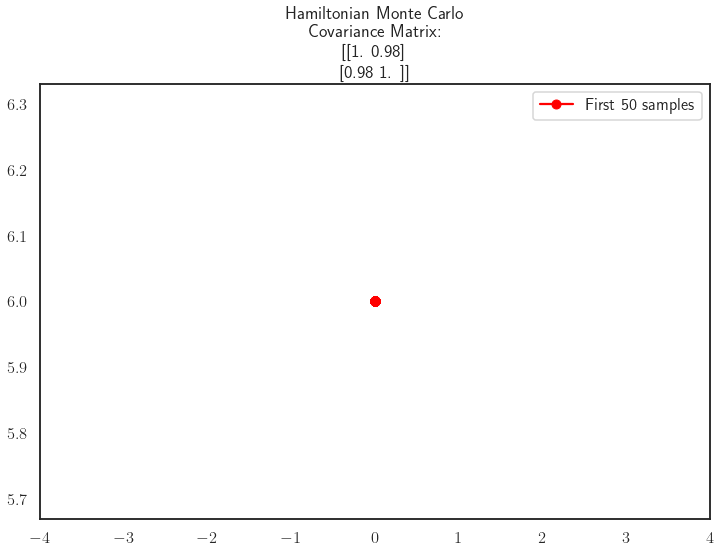

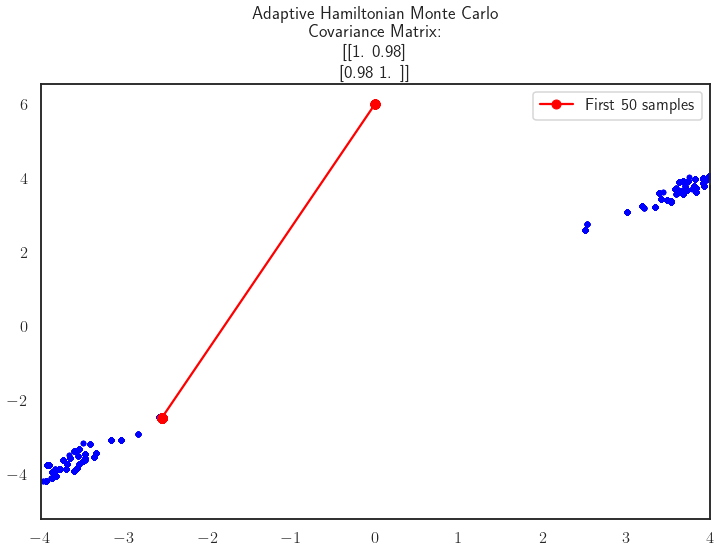

In [72]:
compare_and_plot(M = M, L = 20, delta = 0.05)